# Results intersections #

### Parameters ###
Will be overriden by results_intersections.yaml

In [363]:
#Parameters
threshold = 0.3
min_main_repeats = 9
min_other_repeats = 3
trait = "lifespan"
life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True

In [364]:
from pathlib import Path
import sys
import inspect

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '..', '..', '..', '..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
from typing import *
from yspecies import *
from yspecies.workflow import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.config import *

In [366]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [367]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Load pathes ###

In [368]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [369]:
external = shap_results = locations.output.external 
intersections = locations.output.intersections
shap = external.shap
linear = external.linear
causality = external.dir / "causality"
folder = linear / f"R2_THRESHOLD_{int(threshold * 100)}"

In [370]:
stage_one = locations.output.stage_one
stage_two = locations.output.stage_two
(stage_one, stage_two)

(PosixPath('../data/output/stage_1'), PosixPath('../data/output/stage_2'))

### Function to mark pro and anti genes ###

In [371]:
#used to evaluate the direction
def mark_direction(row, threshold: float, column: str = "mean_kendall_tau", max_repeats: int = 10):    
    cor = row[column] / max_repeats * row["repeats"]
    if cor >= threshold * 2:
        return "strong pro"
    if cor >= threshold:
        return "pro"
    elif cor > 0.0:
        return "weak pro"
    elif round(cor, 4) == 0.0:
        return "neutral"
    elif cor >= -threshold:
        return "weak anti"
    elif cor <= -threshold * 2:
        return "strong anti"
    else:
        return "anti"

## Summarize lifespan results by lifehistories ##

In [372]:
value_cols = ['repeats', 'mean_abs_shap', 'mean_kendall_tau']
value_cols_directed = value_cols + ["direction"]
cols = ['reference_gene','symbol'] + value_cols
cols

['reference_gene', 'symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau']

In [373]:
def load_trait(path: Path, cols: list, min_repeats = 1):
    df = pd.read_csv(path, sep="\t")[cols].set_index("reference_gene")
    df = df[df.repeats >= min_repeats]
    df["direction"] = df.apply(lambda row: mark_direction(row, threshold=threshold), axis=1)
    return df

In [374]:
main_trait_stage_1 = load_trait(stage_one / f"{trait}_selected.tsv", cols, 1)
main_trait_stage_2 = load_trait(stage_two / f"{trait}.tsv", cols, min_main_repeats)
main_trait = main_trait_stage_2.join(main_trait_stage_1[value_cols_directed], rsuffix=f"_{trait}_stage_1")
print(main_trait.shape)
main_trait

(51, 9)


,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1
reference_gene,,,,,,,,,
ENSG00000010219,DYRK4,10.000,2.511,0.440,pro,10.000,2.384,0.325,pro
ENSG00000204498,NFKBIL1,10.000,2.020,-0.420,anti,10.000,1.859,-0.128,weak anti
ENSG00000167515,TRAPPC2L,10.000,1.701,-0.397,anti,10.000,1.543,-0.279,weak anti
ENSG00000066923,STAG3,10.000,1.158,0.489,pro,9.000,0.962,0.480,pro
ENSG00000105672,ETV2,10.000,1.114,0.669,strong pro,10.000,1.018,0.713,strong pro
ENSG00000170835,CEL,10.000,0.966,0.694,strong pro,10.000,1.068,0.693,strong pro
ENSG00000092529,CAPN3,10.000,0.962,0.505,pro,4.000,0.365,0.414,weak pro
ENSG00000106554,CHCHD3,10.000,0.870,-0.560,anti,6.000,0.540,-0.387,weak anti
ENSG00000185880,TRIM69,10.000,0.767,-0.027,weak anti,10.000,0.942,0.097,weak pro


In [375]:
other_life_history = [t for t in life_history if not t == trait]
other_traits = OrderedDict([(t, load_trait(stage_one / (t + "_selected.tsv"), cols, min_other_repeats)) for t in other_life_history])
other_traits["gestation_days"].head(10)

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction
reference_gene,,,,,
ENSG00000006282,SPATA20,10.000,14.669,0.671,strong pro
ENSG00000171121,KCNMB3,10.000,7.212,0.635,strong pro
ENSG00000105672,ETV2,10.000,2.401,0.681,strong pro
ENSG00000188747,NOXA1,9.000,3.168,0.625,pro
ENSG00000165568,AKR1E2,9.000,2.615,-0.504,anti
ENSG00000101190,TCFL5,9.000,1.691,0.660,pro
ENSG00000172531,PPP1CA,9.000,1.284,-0.768,strong anti
ENSG00000066923,STAG3,8.000,5.666,0.430,pro
ENSG00000010219,DYRK4,8.000,2.100,0.454,pro


In [376]:
joined = main_trait
for t,v in other_traits.items():
    joined = joined.join(v, rsuffix = f"_{t}")#
#joined.to_csv(locations.output.stage_two / "lifespan_with_traits.tsv", sep="\t", index_label="reference_gene")
joined.columns

Index(['symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau', 'direction',
       'repeats_lifespan_stage_1', 'mean_abs_shap_lifespan_stage_1',
       'mean_kendall_tau_lifespan_stage_1', 'direction_lifespan_stage_1',
       'symbol_mass_kg', 'repeats_mass_kg', 'mean_abs_shap_mass_kg',
       'mean_kendall_tau_mass_kg', 'direction_mass_kg', 'symbol_mtGC',
       'repeats_mtGC', 'mean_abs_shap_mtGC', 'mean_kendall_tau_mtGC',
       'direction_mtGC', 'symbol_metabolic_rate', 'repeats_metabolic_rate',
       'mean_abs_shap_metabolic_rate', 'mean_kendall_tau_metabolic_rate',
       'direction_metabolic_rate', 'symbol_temperature', 'repeats_temperature',
       'mean_abs_shap_temperature', 'mean_kendall_tau_temperature',
       'direction_temperature', 'symbol_gestation_days',
       'repeats_gestation_days', 'mean_abs_shap_gestation_days',
       'mean_kendall_tau_gestation_days', 'direction_gestation_days'],
      dtype='object')

In [377]:
row = joined.iloc[0]
def summarize_life_history(row: pd.Series):   
    acc = []
    for t in other_life_history:
         rep = row[f"repeats_{t}"]
         if rep >= min_other_repeats:
           sh = row[f"mean_abs_shap_{t}"]
           tau = row[f"mean_kendall_tau_{t}"]
           direction = row[f"direction_{t}"]
           acc.append(f"{t} ({direction} | {int(rep)} | {round(sh,2)} | {round(tau,4)})")
    return ", ".join(acc)
summarize_life_history(row)

'mass_kg (weak pro | 3 | 0.12 | 0.2595), gestation_days (pro | 8 | 2.1 | 0.4539)'

In [378]:
joined["other_life_history_traits"] = joined.apply(summarize_life_history, axis=1)
shap_results = joined[main_trait.columns.to_list()+["other_life_history_traits"]]
shap_results.to_csv(locations.output.stage_two / "shap_results.tsv", sep="\t", index_label="reference_gene")
shap_results

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits
reference_gene,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,2.511,0.440,pro,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat..."
ENSG00000204498,NFKBIL1,10.000,2.020,-0.420,anti,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab..."
ENSG00000167515,TRAPPC2L,10.000,1.701,-0.397,anti,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983)
ENSG00000066923,STAG3,10.000,1.158,0.489,pro,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat..."
ENSG00000105672,ETV2,10.000,1.114,0.669,strong pro,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806)
ENSG00000170835,CEL,10.000,0.966,0.694,strong pro,10.000,1.068,0.693,strong pro,
ENSG00000092529,CAPN3,10.000,0.962,0.505,pro,4.000,0.365,0.414,weak pro,
ENSG00000106554,CHCHD3,10.000,0.870,-0.560,anti,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475)
ENSG00000185880,TRIM69,10.000,0.767,-0.027,weak anti,10.000,0.942,0.097,weak pro,


### Load linear ###

In [195]:
def lag_linear(df: pd.DataFrame)->pd.DataFrame:
    df["MLS_influence_linear"] = df.apply(lambda row: "pro" if row["maxlifespan_sign"]>0 else "anti", axis = 1)
    selected = df[["reference_gene","symbol","organ","maxlifespan_adjpval","maxlifespan_r2_adj", "MLS_influence_linear"]].sort_values(by="maxlifespan_r2_adj", ascending=False).drop_duplicates()
    selected["organ"] = selected.apply(lambda row: row["organ"] + " (" +row["MLS_influence_linear"]+" r^2=" + str(round(row["maxlifespan_r2_adj"],4)) +")", axis=1)
    return selected[["reference_gene","symbol","organ"]].groupby(["reference_gene", "symbol"], as_index=False).agg({'organ': ', '.join}).set_index("reference_gene")


In [196]:
linear_organ = lag_linear(pd.read_csv(folder / "linear_models_on_species_vars.csv").rename(columns={"Unnamed: 0": "reference_gene"}))
linear_organ.head()

,symbol,organ
reference_gene,,
ENSG00000000003,TSPAN6,Liver (pro r^2=0.4136)
ENSG00000001036,FUCA2,"Brain (anti r^2=0.3894), Heart (anti r^2=0.3263)"
ENSG00000001497,LAS1L,Heart (anti r^2=0.507)
ENSG00000003402,CFLAR,Heart (pro r^2=0.3485)
ENSG00000003436,TFPI,Brain (anti r^2=0.3418)


# Join with linear models #

In [197]:
shap_with_linear = shap_results.join(linear_organ["organ"])
shap_with_linear.to_csv(locations.output.dir / "results" / "shap_with_linear.tsv", sep="\t", index_label="reference_gene")
shap_with_linear

,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ
reference_gene,,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,2.511,0.440,pro,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat...",Heart (pro r^2=0.3529)
ENSG00000204498,NFKBIL1,10.000,2.020,-0.420,anti,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab...",NaN
ENSG00000167515,TRAPPC2L,10.000,1.701,-0.397,anti,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983),"Brain (anti r^2=0.5246), Heart (anti r^2=0.3671)"
ENSG00000066923,STAG3,10.000,1.158,0.489,pro,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat...",NaN
ENSG00000105672,ETV2,10.000,1.114,0.669,strong pro,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806),NaN
ENSG00000170835,CEL,10.000,0.966,0.694,strong pro,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815)
ENSG00000092529,CAPN3,10.000,0.962,0.505,pro,4.000,0.365,0.414,weak pro,,"Kidney (pro r^2=0.4455), Heart (pro r^2=0.4098)"
ENSG00000106554,CHCHD3,10.000,0.870,-0.560,anti,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475),"Brain (anti r^2=0.4242), Heart (anti r^2=0.394)"
ENSG00000185880,TRIM69,10.000,0.767,-0.027,weak anti,10.000,0.942,0.097,weak pro,,NaN


# Genage annotations #

In [198]:
genage_folder = locations.input.annotations.genage

genage_conversions = pd.read_csv(genage_folder.conversion, sep="\t")
genage = genage_conversions[["Ensembl","Gene Symbol", "Organism", "Lifespan Effect", "Longevity Influence", "Method"]].drop_duplicates()
genage.head(10)

,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method
0,YPL174C,NIP100,Saccharomyces cerevisiae,decrease,fitness,Deletion
1,YER091C,MET6,Saccharomyces cerevisiae,decrease,fitness,Deletion
2,YDR108W,TRS85,Saccharomyces cerevisiae,decrease,fitness,Deletion
4,YMR135C,GID8,Saccharomyces cerevisiae,decrease,fitness,Deletion
6,YCR024C-A,PMP1,Saccharomyces cerevisiae,decrease,fitness,Deletion
7,YDR181C,SAS4,Saccharomyces cerevisiae,increase,anti,Deletion
8,YJL210W,PEX2,Saccharomyces cerevisiae,decrease,fitness,Deletion
9,YNL079C,TPM1,Saccharomyces cerevisiae,decrease,fitness,Deletion
10,YJR127C,RSF2,Saccharomyces cerevisiae,decrease,fitness,Deletion
11,YMR307W,GAS1,Saccharomyces cerevisiae,decrease,fitness,Deletion


In [199]:
genage_genes = pd.read_csv(genage_folder.orthologs.dir / "all.tsv", sep="\t").rename(columns={"Homo_sapiens":"reference_gene"})
genage_genes.head(5)

,reference_gene,Caenorhabditis_elegans,Drosophila_melanogaster,Mus_musculus,Mesocricetus_auratus,Danio_rerio
0,ENSG00000242265,NaN,NaN,ENSMUSG00000092035,ENSMAUG00000018656,ENSDARG00000109342
1,ENSG00000139990,WBGene00011242,FBgn0250755,ENSMUSG00000049106,ENSMAUG00000004350,ENSDARG00000060320
2,ENSG00000073921,WBGene00006751,FBgn0086372,ENSMUSG00000039361,ENSMAUG00000011448,ENSDARG00000012866;ENSDARG00000014137
3,ENSG00000139687,WBGene00003020,NaN,ENSMUSG00000022105,ENSMAUG00000020865,ENSDARG00000006782
4,ENSG00000119977,WBGene00017120,NaN,ENSMUSG00000025008,ENSMAUG00000021808,NaN


In [200]:
genage_humanized = genage.head(0)
for c in genage_genes.columns[1:]:
    col = c.replace("_", " ")
    selected_genes = genage_genes[["reference_gene",c]].rename(columns = {c:"Ensembl"}).dropna()
    selected_genes["Ensembl"] = selected_genes.apply(lambda row: row["Ensembl"].split(";"),1)
    genage_org = genage[genage["Organism"]==col]
    merged = selected_genes.explode("Ensembl").merge(genage_org, on="Ensembl", how="inner")
    genage_humanized = pd.concat([genage_humanized, merged])
genage_humanized = genage_humanized.drop_duplicates()
genage_humanized.head(10)

,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method,reference_gene
0,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000095917
1,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000116176
2,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000172236
3,WBGene00006619,try-1,Caenorhabditis elegans,increase,anti,RNA interference,ENSG00000197253
4,WBGene00004481,rps-12,Caenorhabditis elegans,increase,anti,Post-developmental RNA interference,ENSG00000112306
5,WBGene00004789,sgk-1,Caenorhabditis elegans,increase,anti,Deletion,ENSG00000101049
6,WBGene00004789,sgk-1,Caenorhabditis elegans,increase,anti,Deletion,ENSG00000104205
7,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000087053
8,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000063601
9,WBGene00003476,mtm-3,Caenorhabditis elegans,decrease,pro,RNA interference,ENSG00000003987


### Add genage human info ###

In [201]:
genage_human = pd.read_csv(genage_folder.human, sep='\t')
genage_human.shape

(307, 6)

### Check for genage genes ###

In [202]:
shap_with_linear_genage = shap_with_linear.merge(genage_humanized, on="reference_gene")
shap_with_linear_genage.to_csv(locations.output.dir / "results" / "genage_intersection.tsv", index_label="reference_gene", sep="\t")
shap_with_linear_genage

,reference_gene,symbol,repeats,mean_abs_shap,mean_kendall_tau,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ,Ensembl,Gene Symbol,Organism,Lifespan Effect,Longevity Influence,Method
0,ENSG00000162959,MEMO1,10.000,0.390,-0.628,strong anti,nan,nan,nan,NaN,gestation_days (weak anti | 7 | 1.35 | -0.2135),"Heart (anti r^2=0.4534), Brain (anti r^2=0.444...",WBGene00016500,memo-1,Caenorhabditis elegans,increase,anti,Mutation
1,ENSG00000164362,TERT,10.000,0.385,-0.450,anti,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",ENSMUSG00000021611,Tert,Mus musculus,increase,pro,Overexpression
2,ENSG00000164362,TERT,10.000,0.385,-0.450,anti,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",ENSMUSG00000021611,Tert,Mus musculus,increase,pro,Knockin
3,ENSG00000164362,TERT,10.000,0.385,-0.450,anti,4.000,0.119,-0.466,weak anti,"mtGC (weak anti | 5 | 0.02 | -0.517), gestatio...","Heart (anti r^2=0.4954), Liver (anti r^2=0.4836)",ENSDARG00000042637,tert,Danio rerio,decrease,pro,Mutation
4,ENSG00000204231,RXRB,10.000,0.313,-0.609,strong anti,4.000,0.097,-0.152,weak anti,,NaN,WBGene00007547,nhr-154,Caenorhabditis elegans,increase,anti,RNA interference
5,ENSG00000140398,NEIL1,10.000,0.172,0.762,strong pro,2.000,0.022,0.661,weak pro,,NaN,ENSMUSG00000032298,Neil1,Mus musculus,decrease,pro,Knockout
6,ENSG00000175806,MSRA,10.000,0.119,-0.232,weak anti,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),FBgn0000565,Eip71CD,Drosophila melanogaster,increase,pro,Overexpression
7,ENSG00000175806,MSRA,10.000,0.119,-0.232,weak anti,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),ENSMUSG00000054733,Msra,Mus musculus,decrease,pro,Knockout
8,ENSG00000175806,MSRA,10.000,0.119,-0.232,weak anti,nan,nan,nan,NaN,metabolic_rate (weak anti | 4 | 0.64 | -0.0479),Kidney (anti r^2=0.3019),ENSMUSG00000054733,Msra,Mus musculus,NaN,NaN,Mutations
9,ENSG00000142937,RPS8,10.000,0.107,0.620,strong pro,nan,nan,nan,NaN,mtGC (weak pro | 3 | 0.0 | 0.4755),NaN,WBGene00004477,rps-8,Caenorhabditis elegans,increase,anti,RNA interference


# Causality #

### Intesection ###

In [203]:
causal = pd.read_csv(causality / "causal_selection.tsv", sep="\t").rename(columns={"Gene Code" : "reference_gene", "Gene Name": "symbol", "Relative Frequency": "frequency"}).set_index("reference_gene")
causal.head(10)

,symbol,frequency
reference_gene,,
ENSG00000188747,NOXA1,1.000
ENSG00000198663,C6orf89,0.940
ENSG00000115488,NEU2,0.940
ENSG00000184983,NDUFA6,0.900
ENSG00000151962,RBM46,0.820
ENSG00000171121,KCNMB3,0.720
ENSG00000170835,CEL,0.600
ENSG00000136436,CALCOCO2,0.420
ENSG00000129187,DCTD,0.400


In [204]:
shap_with_linear_causal = shap_with_linear.join(causal["frequency"])[shap_with_linear.columns.insert(4,'frequency')]
shap_with_linear_causal_inner = shap_with_linear_causal[shap_with_linear_causal.frequency>0]
print(shap_with_linear_causal_inner.shape)
shap_with_linear_causal_inner

(12, 12)


,symbol,repeats,mean_abs_shap,mean_kendall_tau,frequency,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ
reference_gene,,,,,,,,,,,,
ENSG00000170835,CEL,10.000,0.966,0.694,0.600,strong pro,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815)
ENSG00000092529,CAPN3,10.000,0.962,0.505,0.320,pro,4.000,0.365,0.414,weak pro,,"Kidney (pro r^2=0.4455), Heart (pro r^2=0.4098)"
ENSG00000171121,KCNMB3,10.000,0.614,0.640,0.720,strong pro,8.000,0.586,0.610,pro,"mtGC (strong pro | 10 | 0.39 | 0.6245), gestat...","Brain (pro r^2=0.4583), Lung (pro r^2=0.4067),..."
ENSG00000132436,FIGNL1,10.000,0.602,0.557,0.020,pro,9.000,0.540,0.570,pro,gestation_days (weak pro | 5 | 0.42 | 0.4068),"Lung (pro r^2=0.4682), Brain (pro r^2=0.3752)"
ENSG00000165501,LRR1,10.000,0.385,0.717,0.340,strong pro,9.000,0.177,0.688,strong pro,,"Heart (pro r^2=0.4585), Lung (pro r^2=0.4286),..."
ENSG00000136436,CALCOCO2,10.000,0.345,0.755,0.420,strong pro,4.000,0.074,0.722,weak pro,,"Lung (pro r^2=0.5586), Brain (pro r^2=0.5369),..."
ENSG00000142002,DPP9,10.000,0.317,-0.773,0.300,strong anti,7.000,0.101,-0.716,anti,,"Lung (anti r^2=0.5074), Heart (anti r^2=0.3048)"
ENSG00000188747,NOXA1,9.000,0.551,0.689,1.000,strong pro,9.000,0.413,0.689,strong pro,"mtGC (pro | 8 | 0.05 | 0.649), gestation_days ...","Brain (pro r^2=0.6271), Kidney (pro r^2=0.6017..."
ENSG00000134489,HRH4,9.000,0.419,0.617,0.040,pro,4.000,0.259,0.641,weak pro,,Lung (pro r^2=0.5431)


### Statistics ###

In [205]:
relevant_genes = shap_with_linear_causal[shap_with_linear_causal.mean_abs_shap >= 0.1]

In [206]:
",".join(relevant_genes[relevant_genes.mean_abs_shap >= 1].symbol.to_list())

'DYRK4,NFKBIL1,TRAPPC2L,STAG3,ETV2'

In [207]:
print("PRO GENES:")
print(f"strong pro genes: {relevant_genes[relevant_genes['direction'] =='strong pro'].shape[0]}")
print(f"pro genes: {relevant_genes[relevant_genes['direction'] == 'pro'].shape[0]}")
print(f"weak pro genes: {relevant_genes[relevant_genes['direction'] == 'weak pro'].shape[0]}")
print("\nANTI GENES:")
print(f"strong anti genes: {relevant_genes[relevant_genes['direction'] =='strong anti'].shape[0]}")
print(f"anti genes: {relevant_genes[relevant_genes['direction'] == 'anti'].shape[0]}")
print(f"weak anti genes: {relevant_genes[relevant_genes['direction'] == 'weak anti'].shape[0]}")
print(f">1 years{relevant_genes[relevant_genes.mean_abs_shap >= 1].symbol.values}")

PRO GENES:
strong pro genes: 10
pro genes: 12
weak pro genes: 0

ANTI GENES:
strong anti genes: 7
anti genes: 15
weak anti genes: 3
>1 years['DYRK4' 'NFKBIL1' 'TRAPPC2L' 'STAG3' 'ETV2']


Best kendall tau genes
======================

In [208]:
# >= 0.6 strong pro
# >= 0.3 pro
# > 0.0 weak pro
# < 0.0 weak anti
# <= -0.3 anti
# <= -0.6 strong anti
best_kendall_max = relevant_genes[relevant_genes.mean_kendall_tau >= 0.6].sort_values(by="mean_kendall_tau", ascending=False)[["symbol", "mean_kendall_tau"]]
best_kendall_min = relevant_genes[relevant_genes.mean_kendall_tau <= -0.6].sort_values(by="mean_kendall_tau", ascending=True)[["symbol", "mean_kendall_tau"]]
print(best_kendall_max.shape, best_kendall_min.shape)
print(f"with MAX {best_kendall_max.symbol.to_list()} and MIN {best_kendall_min.symbol.to_list()}")

(13, 2) (10, 2)
with MAX ['NOXRED1', 'NEIL1', 'CALCOCO2', 'LRR1', 'C1orf56', 'CEL', 'NOXA1', 'ETV2', 'KCNMB3', 'RPS8', 'HRH4', 'GTF3A', 'SPAG16'] and MIN ['C6orf89', 'PPP1CA', 'DPP9', 'VARS2', 'CTBS', 'CAGE1', 'MRTO4', 'ZWINT', 'MEMO1', 'RXRB']


In [209]:
best_kendall_max.symbol.to_list()[:10]

['NOXRED1',
 'NEIL1',
 'CALCOCO2',
 'LRR1',
 'C1orf56',
 'CEL',
 'NOXA1',
 'ETV2',
 'KCNMB3',
 'RPS8']

# Saving results #

In [210]:
shap_with_linear_causal.to_csv(intersections / "intersections.tsv", sep = "\t", index = True)
#all_ext.to_csv(intersections / "intersections_5_and_7.tsv", sep = "\t", index = False)

In [211]:
#all_ext_genage.to_csv(intersections / "genage_model_intersections.tsv", sep = "\t", index = False)
#all_ext_human_genage.to_csv(intersections / "genage_human_intersections.tsv", sep = "\t", index = False)

In [212]:
shap_with_linear_causal

,symbol,repeats,mean_abs_shap,mean_kendall_tau,frequency,direction,repeats_lifespan_stage_1,mean_abs_shap_lifespan_stage_1,mean_kendall_tau_lifespan_stage_1,direction_lifespan_stage_1,other_life_history_traits,organ
reference_gene,,,,,,,,,,,,
ENSG00000010219,DYRK4,10.000,2.511,0.440,nan,pro,10.000,2.384,0.325,pro,"mass_kg (weak pro | 3 | 0.12 | 0.2595), gestat...",Heart (pro r^2=0.3529)
ENSG00000204498,NFKBIL1,10.000,2.020,-0.420,nan,anti,10.000,1.859,-0.128,weak anti,"mass_kg (weak anti | 4 | 0.2 | -0.1118), metab...",NaN
ENSG00000167515,TRAPPC2L,10.000,1.701,-0.397,nan,anti,10.000,1.543,-0.279,weak anti,mtGC (anti | 7 | 0.02 | -0.4983),"Brain (anti r^2=0.5246), Heart (anti r^2=0.3671)"
ENSG00000066923,STAG3,10.000,1.158,0.489,nan,pro,9.000,0.962,0.480,pro,"mass_kg (weak pro | 4 | 0.26 | 0.2807), gestat...",NaN
ENSG00000105672,ETV2,10.000,1.114,0.669,nan,strong pro,10.000,1.018,0.713,strong pro,gestation_days (strong pro | 10 | 2.4 | 0.6806),NaN
ENSG00000170835,CEL,10.000,0.966,0.694,0.600,strong pro,10.000,1.068,0.693,strong pro,,Brain (pro r^2=0.4815)
ENSG00000092529,CAPN3,10.000,0.962,0.505,0.320,pro,4.000,0.365,0.414,weak pro,,"Kidney (pro r^2=0.4455), Heart (pro r^2=0.4098)"
ENSG00000106554,CHCHD3,10.000,0.870,-0.560,nan,anti,6.000,0.540,-0.387,weak anti,metabolic_rate (weak anti | 3 | 0.0 | -0.3475),"Brain (anti r^2=0.4242), Heart (anti r^2=0.394)"
ENSG00000185880,TRIM69,10.000,0.767,-0.027,nan,weak anti,10.000,0.942,0.097,weak pro,,NaN


Plot distributions of genes

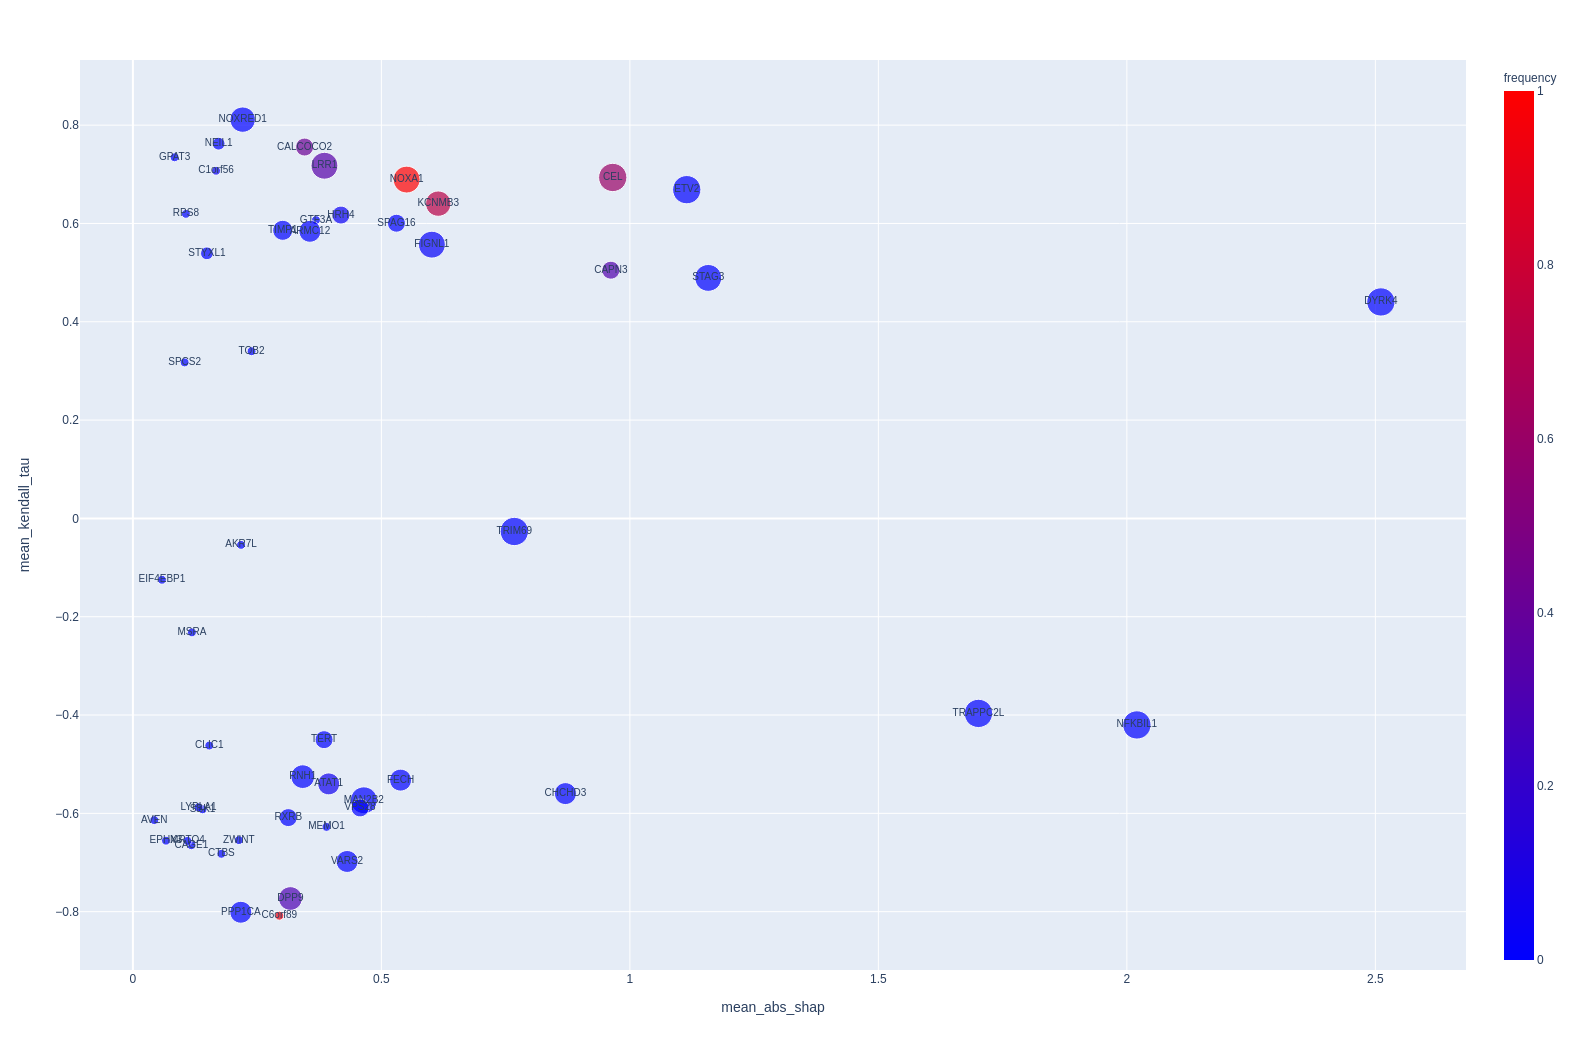

In [255]:
import pandas as pd
pd.options.plotting.backend = "plotly"
shap_plot = shap_with_linear_causal.copy()
shap_plot['repeats_lifespan_stage_1'] = shap_plot['repeats_lifespan_stage_1'].replace(np.nan, 1)
shap_plot['frequency'] = shap_plot['frequency'].replace(np.nan, 0)

fig = shap_plot.plot.scatter(x="mean_abs_shap", y="mean_kendall_tau", size="repeats_lifespan_stage_1", text="symbol", color_continuous_scale="Bluered",  height=1050, width=1400, color="frequency")
fig = fig.for_each_trace(lambda t: t.update(textfont_size=10))
fig.show()

In [359]:
shap_ranked = shap_with_linear_causal.copy()
shap_ranked.columns


Index(['symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau', 'frequency',
       'direction', 'repeats_lifespan_stage_1',
       'mean_abs_shap_lifespan_stage_1', 'mean_kendall_tau_lifespan_stage_1',
       'direction_lifespan_stage_1', 'other_life_history_traits', 'organ'],
      dtype='object')

In [360]:
shap_ranked.columns

Index(['symbol', 'repeats', 'mean_abs_shap', 'mean_kendall_tau', 'frequency',
       'direction', 'repeats_lifespan_stage_1',
       'mean_abs_shap_lifespan_stage_1', 'mean_kendall_tau_lifespan_stage_1',
       'direction_lifespan_stage_1', 'other_life_history_traits', 'organ'],
      dtype='object')

In [361]:
rank_method = "average"

shap_ranked["shap_rank"] = shap_ranked.mean_abs_shap.rank(ascending=False,method=rank_method )

shap_ranked['repeats_lifespan_stage_1'] =shap_ranked['repeats_lifespan_stage_1'].replace(np.nan, 0)
shap_ranked['frequency'] = shap_ranked['frequency'].replace(np.nan, 0)
shap_ranked['frequency_rank'] = shap_ranked['frequency'].rank(ascending=False,method=rank_method)

shap_ranked["mean_kendall_tau"] = shap_ranked['mean_kendall_tau'].replace(np.nan, 0)
shap_ranked["kendall_tau_abs"] = shap_ranked['mean_kendall_tau'].abs()
shap_ranked["kendall_tau_rank"] = shap_ranked['kendall_tau_abs'].rank(ascending=False,method=rank_method )

shap_ranked["repeats_all"] = shap_ranked['repeats'] + shap_ranked['repeats_lifespan_stage_1']
shap_ranked["repeats_rank"] = shap_ranked["repeats_all"].rank(ascending=False,method=rank_method )
shap_ranked["ranks_sum"] = shap_ranked["repeats_rank"] + shap_ranked["kendall_tau_rank"] + shap_ranked["shap_rank"]
shap_ranked["rank"] =shap_ranked["ranks_sum"].rank(ascending=True, method=rank_method)

shap_ranked = shap_ranked.reindex(columns=['symbol',"rank","ranks_sum",
                                           "repeats_rank", 'shap_rank', "kendall_tau_rank", "frequency_rank",  
                                           "repeats_all",  'repeats',  'mean_abs_shap', 'mean_kendall_tau', 'frequency',
       'direction', 'repeats_lifespan_stage_1',
       'mean_abs_shap_lifespan_stage_1', 'mean_kendall_tau_lifespan_stage_1',
       'direction_lifespan_stage_1', 'other_life_history_traits', 'organ',])
shap_ranked = shap_ranked.sort_values(by="rank", ascending=True)